# Description 

This notebook demonstrates how to conduct drift detection using CapyMOA. Then test different drift detectors and evaluating detectors based on known drift location. In addition, we compare the functionalities with River. 

# Imports

In [101]:
# CapyMoa
import capymoa.drift.detectors as detectors
from capymoa.drift.detectors import ADWIN
from capymoa.drift.eval_detector import EvaluateDetector
from capymoa.drift.detectors import ABCD
from capymoa.datasets import ElectricityTiny

# River
from river import drift

# Miscellaneous for tracking
import time, tracemalloc, psutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


# Utils

In [3]:
# Generator to yield (x_dict, y) in river format
def capymoa_to_river_stream(stream):
    feature_names = stream.get_schema().get_numeric_attributes()
    for instance in stream:
        x_dict = dict(zip(feature_names, instance.x))
        y = instance.y_index 
        yield x_dict, y

# Start measurements
def start_measurements():
    tracemalloc.start()
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    return start_time, cpu_start

def end_measurements():
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time, cpu_end, current, peak

# Function to plot the results
def plot_results(results, plot_title):
    # Print results for each learner
    for name, scores in results.items():
        rmse_values = [score['RMSE'].get() for score in scores]
        steps = [score['Step'] for score in scores]  
        plt.plot(steps, rmse_values, label=name)

    plt.xlabel("Instance")
    plt.ylabel("Metric")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# CapyMOA

In [ ]:
# Create random data to mimic a data stream
data_stream = np.random.randint(2, size=2000)
# Introduce different distribution on a given range
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

# Get all the detectors available in CapyMOA
all_detectors = detectors.__all__

n_detections = {k: 0 for k in all_detectors}
# Iterate through detectors 
for detector_name in all_detectors:
    detector = getattr(detectors, detector_name)()
    #Iterate through the data stream 
    for i in range(2000):
        detector.add_element(float(data_stream[i]))
        # If the detector detected a drift add it to number of detections
        if detector.detected_change():
            n_detections[detector_name] += 1

print(pd.Series(n_detections))

ADWIN                       1
CUSUM                       2
DDM                         1
EWMAChart                   1
GeometricMovingAverage      1
HDDMAverage               146
HDDMWeighted               88
PageHinkley                 2
RDDM                        1
SEED                        1
STEPD                       1
ABCD                        1
dtype: int64


Now we focus on ADWIN 

In [105]:
detector = ADWIN(delta=0.001)

for i in range(2000):
    detector.add_element(data_stream[i])
    if detector.detected_change():
        print(
            "Change detected in data: " + str(data_stream[i]) + " - at index: " + str(i)
        )

# Detection indices
print("Summary of detections' index: ", detector.detection_index)

# Warning indices
print("Summary of warning detections' index: ", detector.warning_index)

Change detected in data: 7 - at index: 1023
Change detected in data: 11 - at index: 1279
Summary of detections' index:  [1024, 1280]
Summary of warning detections' index:  []


Now we evaluate detectors

A 2-dimensional stream
Change detected at index: 3059


Text(0, 0.5, 'Reconstruction loss')

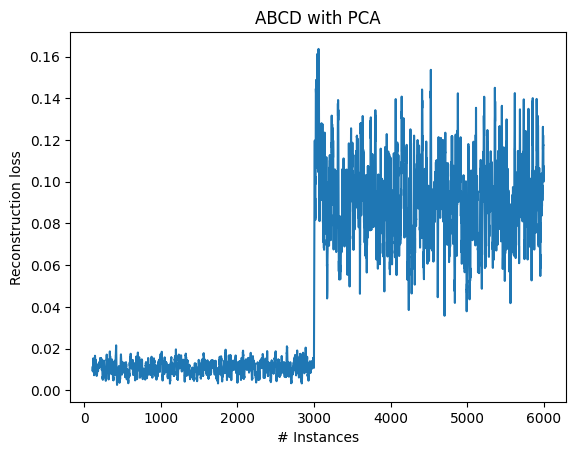

In [104]:
detector = ABCD()

## Opening a file as a stream
stream = ElectricityTiny()

detector = ABCD(model_id="pca")

## Opening a file as a stream
stream_change = np.hstack(
    [np.random.uniform(0, 0.5, 3000), np.random.uniform(0.5, 1.0, 3000)]
)
stream_nochange = np.random.uniform(0, 1.0, len(stream_change))
stream = np.vstack([stream_change, stream_nochange]).T
print(f"A {stream.shape[-1]}-dimensional stream")

i = 0
loss_values = []
while i < len(stream):
    instance = stream[i]
    i += 1
    detector.add_element(instance)
    loss_values.append(detector.loss())
    if detector.detected_change():
        print("Change detected at index: " + str(i))

plt.plot(pd.Series(loss_values).rolling(10).mean())
plt.title("ABCD with PCA")
plt.xlabel("# Instances")
plt.ylabel("Reconstruction loss")

# River

In [ ]:
import inspect 

# Get all the detectors available in CapyMOA
all_detectors = {
    'ADWIN': drift.ADWIN(),
    'PageHinkley': drift.PageHinkley(),
    'Kolmogorov-Smirnov Windowing': drift.KSWIN(alpha=0.0001, seed=42),
}

# Create random data to mimic a data stream
data_stream = np.random.randint(2, size=2000)
# Introduce different distribution on a given range
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

n_detections = {k: 0 for k in all_detectors}
# Iterate through detectors 
for detector_name, detector in all_detectors.items():
    # Iterate through data stream 
    for i in range(2000):
        detector.update(float(data_stream[i]))
        # If the detector detected a drift add it to number of detections
        if detector.drift_detected:
            print(detector_name, f" detected at index: {i}")
            n_detections[detector_name] += 1

print('---------------------')
print(pd.Series(n_detections))


ADWIN  detected at index: 1023
PageHinkley  detected at index: 1002
PageHinkley  detected at index: 1479
Kolmogorov-Smirnov Windowing  detected at index: 1015
---------------------
ADWIN                           1
PageHinkley                     2
Kolmogorov-Smirnov Windowing    1
dtype: int64


In [102]:
# Get all the detectors available in CapyMOA
all_detectors = {
    'Drift Detection Method': drift.binary.DDM(),
    'Early Drift Detection Method': drift.binary.EDDM(alpha=0.8, beta=0.75),
    'Fast Hoeffding Drift Detection Method': drift.binary.FHDDM(short_window_size = 20),
    'Hoeffding Bound Moving Average': drift.binary.HDDM_A(),
    'Hoeffding Bound Weighted Average': drift.binary.HDDM_W()
}

# Create random data to mimic a data stream
rng = random.Random(42)
data_stream = rng.choices([0, 1], k=1000)
data_stream = data_stream + rng.choices([0, 1], k=1000, weights=[0.3, 0.7])

n_detections = {k: {'detections': 0, 'warnings': 0} for k in all_detectors}
for detector_name, detector in all_detectors.items():
    print(detector_name)
    # Iterate through data stream 
    for i, x in enumerate(data_stream):
        detector.update(x)
        if detector.drift_detected:
            print(detector_name, f" detected at index: {i}")
            n_detections[detector_name]['detections'] += 1
        if detector.warning_detected:
            n_detections[detector_name]['warnings'] += 1

print('---------------------')
print(pd.Series(n_detections))

Drift Detection Method
Drift Detection Method  detected at index: 1334
Early Drift Detection Method
Early Drift Detection Method  detected at index: 1278
Fast Hoeffding Drift Detection Method
Fast Hoeffding Drift Detection Method  detected at index: 508
Hoeffding Bound Moving Average
Hoeffding Bound Moving Average  detected at index: 1206
Hoeffding Bound Weighted Average
Hoeffding Bound Weighted Average  detected at index: 1077
---------------------
Drift Detection Method                   {'detections': 1, 'warnings': 587}
Early Drift Detection Method             {'detections': 1, 'warnings': 220}
Fast Hoeffding Drift Detection Method      {'detections': 1, 'warnings': 0}
Hoeffding Bound Moving Average            {'detections': 1, 'warnings': 75}
Hoeffding Bound Weighted Average          {'detections': 1, 'warnings': 14}
dtype: object
